# Convolutional Generative Network for MNIST digits

This practical session is based on the [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

It was adapted by
* Lucía Bouza
* Bruno Galerne
* Arthur Leclaire

You should complete the code regions marked with ###...###.

## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# default directory:
%cd /content/drive/MyDrive/Colab\ Notebooks
# we advise to create a specific directory on your Google drive:
%cd /content/drive/MyDrive/genmod2425

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/genmod2425


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
!nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
      img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda
Tue Feb  4 10:41:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------------

## Download MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [ ]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

**QUESTION:** Draw a batch of real images with the train_loader and display them. Use `next` and `iter` to get a batch from `train_loader`.

torch.Size([128, 1, 28, 28])


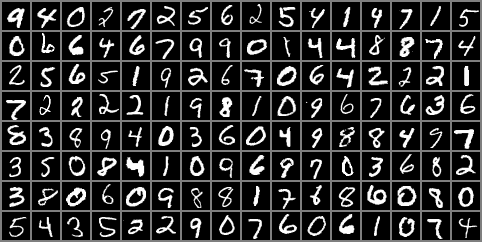

In [ ]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

## Generator and Discriminator Models

The architecture guidelines for stable DCGANs mentioned in the [paper](https://arxiv.org/pdf/1511.06434.pdf) are:
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator). See this [github site](https://github.com/vdumoulin/conv_arithmetic) to view animations of all kind of convolutions.
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

**The generator** maps $z$ (a latent space vector sampled from a standard normal distribution) to data-space (in our case images the MNIST images having size 1x28x28).

In practice, this is accomplished through a series of Conv2DTranspose (Upsampling) layers each paired with a 2D batch norm layer and a Relu activation. We upsample the image three times so as to reach the desired image size. The output of the generator is fed through a tanh function to return it to the input data range of [-1,1].

**The discriminator** outputs the probability that the input (an image) came from real MNIST images rather than the generator.

In practice, this is accomplished through a series of Conv2d, 2D batch norm, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function.

In [ ]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
import torchsummary

# Create some generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)
torchsummary.summary(G, input_size=(nz,1,1))
torchsummary.summary(D, input_size=(1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]              64
             Tanh-14            [-1, 1,

## Display Samples of the Generator

z = torch.Size([128, 100, 1, 1])


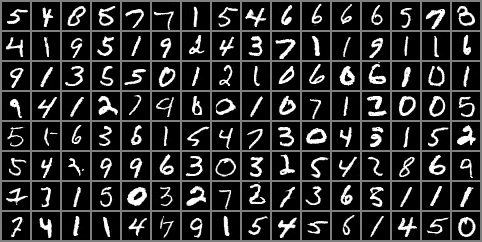

In [ ]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
      print(f"z = {z.size()}")
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

# Load a pre-learned generator to see what you will get at the end of the practical session!:
G = Generator().to(device)
G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))

# Display samples
show(G)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

z = torch.Size([128, 100, 1, 1])


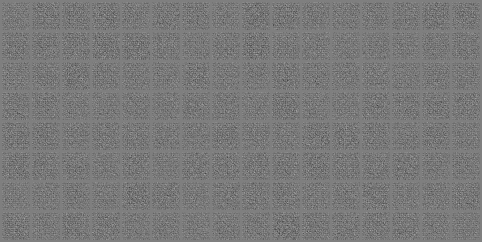

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

<br/><br/><br/><br/><br/>

# Exercise 1: DCGAN Training with WGAN-GP loss

<br/><br/>


**QUESTION:** Implement functions to estimate the Lipschitz constant and Gradient Penalty of the discriminator, and test them.

In [ ]:
def lipconstant(D,x,y):

    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,1,1,1),device=device)
    print(f"alpha = {alpha.size()}")
    # interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp = (alpha * y + (1 - alpha) * x).flatten(end_dim=1)
    interp.requires_grad_()

    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs = Di, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients**2,dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

#### (lip constant of the current D) ###

def gradient_penalty(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y + (1 - alpha) * x).flatten(end_dim=1)
    interp.requires_grad_()

    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs = Di, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients**2,dim=1))

    # Return gradient penalty
    return torch.mean((gradients_norm-1)**2)

# draw a batch of real samples
y = next(iter(train_loader))[0].to(device)

# draw a batch of fake samples
nz = 100  # dimension
z = torch.randn(batch_size,nz,1,1).to(device)
x = G(z)

print(f"y = {y.size()}")
print(f"x = {x.size()}")

print(lipconstant(D,x,y))
print(gradient_penalty(D,x,y))

y = torch.Size([128, 1, 28, 28])
x = torch.Size([128, 1, 28, 28])
alpha = torch.Size([128, 1, 1, 1])


RuntimeError: Given groups=1, weight of size [64, 1, 4, 4], expected input[1, 128, 28, 28] to have 1 channels, but got 128 channels instead

**QUESTION:** Implement WGAN-GP training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the discriminator loss <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the generator loss <br/>
> > Compute the gradient and do an optimizer step for the generator parameters

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 5
log_every = 100
gpw = 0.1

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size,nz,1,1).to(device)

t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(train_loader, 0):

        ############################
        # Draw Batches of real and fake images

        ### ... ###

        ############################
        # Update D network

        ### ... ###

        ############################
        # Update G network

        ### ... ###

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(),lipconstant(D,real,faked)))
            show(G,zviz)

print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())

# Save final generator in a file
torch.save(G.state_dict(), 'wgan.pt')

<br/><br/><br/><br/><br/>

# Exercise 2: Let's play with the Generator

## Interpolation in latent space:

**QUESTION:**
Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$.

Display all the images in a grid of height 10 and width 20 images.

In [ ]:
# # Uncomment the following lines if you want to load a pretrained generator:
# G = Generator().to(device)
# G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))


G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

minib = 10    # number of latent variables
nk = 30       # number of alpha values

### ... ###

pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=nk))

## Nearest Neighbor in the Dataset


In [ ]:
# extract all the database
train_loader_all = data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y,labels = next(iter(train_loader_all))

# For fun, display parts of the database corresponding to different figures
realzeros = y[labels==0]
realones = y[labels==1]
realtwos = y[labels==2]
realthrees = y[labels==3]
imshow(torchvision.utils.make_grid(realzeros[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realones[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realtwos[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realthrees[0:128,:,:,:].to('cpu'),nrow=16));

**QUESTION:** For several samples of the generative model, compute the nearest neighbors in the whole dataset.

Display the samples and their nearest neighbor side by side.

In [ ]:

x =      # minib samples of the generative model

### ... ###

xnn =    # nearest neighbors in the dataset

im = torch.zeros((minib*2,1,28,28)).to(device)
im[0:minib,:,:,:] = x
im[minib:2*minib,:,:,:] = xnn

imshow(torchvision.utils.make_grid(im.to('cpu'),nrow=10),size=200)